# 1. Import the required libraries

In [1]:
# Standard code libraries
import os
import numpy as np
import matplotlib.pyplot as plt

# Custom code libraries from ReSurfEMG
from resurfemg.helper_functions.config import Config
from resurfemg.data_connector import file_discovery
from resurfemg.pipelines import ipy_widgets
from resurfemg.data_connector.tmsisdk_lite import Poly5Reader
from resurfemg.data_connector.data_classes import (
VentilatorDataGroup, EmgDataGroup)
from resurfemg.preprocessing import envelope as evl


import pywt
import pandas as pd
from scipy.signal import medfilt
from resurfemg.preprocessing import ecg_removal as ecg_rm


config = Config()

%matplotlib widget

## 2. Load sEMG test data

## Synthetic data

In [ ]:
# For the test data:
base_path = config.get_directory('test_data')

files = file_discovery.find_files(
    base_path=base_path,
    file_name_regex='*',
    extension_regex='Poly5',
    folder_levels=None,
    verbose=False
)
button_list = ipy_widgets.file_select(
    files=files,
    folder_levels=['files'],
    default_value_select=None,
    default_idx_select=[0])

## Patient data

In [2]:
# Identify all recordings available for the selected patient/measurement_date

# First find the patients
config = Config()
base_path = config.get_directory('root_patient_data_directory')
patient_paths = file_discovery.find_folders(
    base_path,
    folder_levels=['patient'])
patient = list(patient_paths['patient'].values)[0]

# Then find the files for the selected patients:
folder_levels = ['date', 'measurement']
patient_path = os.path.join(base_path, patient)

emg_files = file_discovery.find_files(
    base_path=patient_path,
    file_name_regex='EMG_recording',
    extension_regex='poly5',
    folder_levels=folder_levels)

folder_levels = ['date', 'measurement']
vent_files = file_discovery.find_files(
    base_path=patient_path,
    file_name_regex='Draeger_recording',
    extension_regex='poly5',
    folder_levels=folder_levels)

button_list = ipy_widgets.file_select(
    emg_files,
    folder_levels=folder_levels,
    default_value_select=None,
    default_idx_select=[1, 6, None])
emg_file_chosen = os.path.join(
    patient_path, *[btn.value for btn in button_list], 'EMG_recording.Poly5')
vent_file_chosen = os.path.join(
    patient_path, *[btn.value for btn in button_list], 'Draeger_recording.Poly5')

print("The chosen files are:\n", emg_file_chosen, '\n', vent_file_chosen)

These files did not match the provided depth:
 [['2021-12-27_09-16-26', '00_Incorrect', '006 - Vroegtijdig gestopt', 'EMG_recording.poly5'], ['2021-12-27_09-16-26', '00_Incorrect', '009 - PS ipv PEEP', 'EMG_recording.poly5'], ['No_NMC', '2021-12-31_10-31-03', '001', 'EMG_recording.poly5'], ['No_NMC', '2021-12-31_10-31-03', '002', 'EMG_recording.poly5'], ['No_NMC', '2021-12-31_10-31-03', '003', 'EMG_recording.poly5'], ['No_NMC', '2021-12-31_10-31-03', '004', 'EMG_recording.poly5'], ['No_NMC', '2021-12-31_10-31-03', '005', 'EMG_recording.poly5'], ['No_NMC', '2021-12-31_10-31-03', '006', 'EMG_recording.poly5'], ['No_NMC', '2021-12-31_10-31-03', '007', 'EMG_recording.poly5'], ['No_NMC', '2021-12-31_10-31-03', '008', 'EMG_recording.poly5']]
These files did not match the provided depth:
 [['2021-12-27_09-16-26', '00_Incorrect', '006 - Vroegtijdig gestopt', 'Draeger_recording.poly5'], ['2021-12-27_09-16-26', '00_Incorrect', '009 - PS ipv PEEP', 'Draeger_recording.poly5'], ['No_NMC', '2021-12-

interactive(children=(Dropdown(description='date:', options=('2021-12-24_09-29-46', '2021-12-27_09-16-26', '20…

The chosen files are:
 P:/TNW/CRPH/Projects/2021_Warnaar_TOPSPIN_studie/4_Patient_data/1_RAW\MST001\2021-12-24_09-29-46\001\EMG_recording.poly5\EMG_recording.Poly5 
 P:/TNW/CRPH/Projects/2021_Warnaar_TOPSPIN_studie/4_Patient_data/1_RAW\MST001\2021-12-24_09-29-46\001\EMG_recording.poly5\Draeger_recording.Poly5


In [4]:
# Load the EMG from the selected folders (synthetic data):
emg_file_chosen = os.path.join(base_path, *[btn.value for btn in button_list])

# # Load the EMG from the selected folders:
# emg_file_chosen = os.path.join(patient_path, *[btn.value for btn in button_list])

data_emg = Poly5Reader(emg_file_chosen)
data_emg_samples = data_emg.samples[:data_emg.num_samples]
fs_emg = data_emg.sample_rate

y_emg = data_emg_samples
t_emg = [i/fs_emg for i in range(len(y_emg[0, :]))]

# Load the Ventilator from the selected folders:
# data_vent = Poly5Reader(vent_file_chosen)
# data_vent_samples = data_vent.samples[:data_vent.num_samples]
# fs_vent = data_vent.sample_rate
# 
# y_vent = data_vent_samples
# t_vent = [i/fs_vent for i in range(len(y_vent[0, :]))]


Reading file  P:/TNW/CRPH/Projects/2021_Warnaar_TOPSPIN_studie/4_Patient_data/1_RAW\MST001\2021-12-24_09-29-46\005\EMG_recording.poly5
	 Number of samples:  972944 
	 Number of channels:  3 
	 Sample rate: 2048 Hz
Done reading data.


In [6]:
# Store the EMG data in a group of TimeSeries objects
if y_emg.shape[0] == 2:
    emg_timeseries_wav_den = EmgDataGroup(
        y_emg,
        fs=fs_emg,
        labels=['ECG', 'EMGdi'],
        units=2*['uV'])
    emg_timeseries_gated = EmgDataGroup(
        y_emg,
        fs=fs_emg,
        labels=['ECG', 'EMGdi'],
        units=2*['uV'])
else:
    emg_timeseries_wav_den = EmgDataGroup(
        y_emg,
        fs=fs_emg,
        labels=['ECG', 'EMGdi', 'EMGpara'],
        units=3*['uV'])
    emg_timeseries_gated = EmgDataGroup(
        y_emg,
        fs=fs_emg,
        labels=['ECG', 'EMGdi', 'EMGpara'],
        units=3*['uV'])


# # Store the ventilator data in a group of TimeSeries objects
# vent_timeseries = VentilatorDataGroup(
#     y_vent,
#     fs=fs_vent,
#     labels=['Paw', 'F', 'Vvent'],
#     units=['cmH2O', 'L/s', 'L'])

Auto-detected ECG channel from labels.
Auto-detected ECG channel from labels.


# 3. Pre-process the data

In [19]:
# Gating for comparison
emg_timeseries_gated.filter(
    signal_type='raw',
    hp_cf=20.0,
    lp_cf=500.0,    
    channel_idxs=None,
)
emg_timeseries_gated.gating()
emg_timeseries_gated.envelope()

Auto-detected ECG channel from labels.


# 4. Perform wavelet transform

In [8]:
# Define swtden
def wavelet_denoising_local(
    x, ecg_peak_idxs, fs, sorh='h', n=4, w='db2', fixed_thresh=4.5):
    """
    Shrinkage Denoising using a-trous wavelet decomposition (SWT)

    This is a Python implementation of the SWT, as previously implemented in
    MATLABby Jan Graßhoff. See Copyright notice below.
    Parameters:
    x -- input signal
    peaks -- R-peak locations
    sorh -- 'h' for hard thresholding, 's' for soft (default: 'h')
    n -- decomposition level (default: 4)
    w -- wavelet type (default: 'db2')
    fixed_thresh -- fixed threshold factor (default: 4.5)

    Returns:
    out -- denoised signal
    wDEC -- wavelet decomposition
    thresholds -- calculated thresholds
    gates -- gating based on R-peaks
    % Copyright 2019 Institute for Electrical Engineering in Medicine, 
    % University of Luebeck
    % Jan Graßhoff
    %
    % Permission is hereby granted, free of charge, to any person obtaining a 
    % copy of this software and associated documentation files (the 
    % "Software"), to deal in the Software without restriction, including 
    % without limitation the rights to use, copy, modify, merge, publish, 
    % distribute, sublicense, and/or sell copies of the Software, and to permit
    % persons to whom the Software is furnished to do so, subject to the 
    % following conditions:
    % 
    % The above copyright notice and this permission notice shall be included 
    % in all copies or substantial portions of the Software.
    % 
    % THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS 
    % OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF 
    % MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. 
    % IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY 
    % CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT
    % OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR 
    % THE USE OR OTHER DEALINGS IN THE SOFTWARE.
    """
    def noise_est(signal, win_len):
        """
        Estimate noise level

        Parameters:
        signal -- input wavelet-decomposed signal
        win_len -- window length for noise estimation

        Returns:
        stdc -- estimated noise level
        """
        nblev = signal.shape[0]
        stdc = np.zeros(signal.shape)

        for k in range(nblev):
            # Estimate stdc from MAD: std ~ MAD/0.6745
            stdc[k, :] = pd.Series(np.abs(signal[k, :])).rolling(
                window=win_len,
                min_periods=1,
                center=True).median().values / 0.6745

            # Correct on- and offset effects
            stdc[k, :win_len // 2] = stdc[k, win_len // 2]
            stdc[k, -win_len // 2:] = stdc[k, -win_len // 2]
        return stdc

    def get_gates(rpeaks, samples):
        """
        Generate gates for the peaks

        Parameters:
        rpeaks -- R-peak locations
        samples -- number of samples to gate around peaks

        Returns:
        gates -- gated signal based on R-peaks
        """
        samples = int(np.floor(samples / 2) * 2)
        rpeak_indx = np.where(rpeaks == 1)[0]

        gates = np.zeros_like(rpeaks)
        for i in range(len(rpeak_indx)):
            gates[
                max(rpeak_indx[i] - samples // 2, 0):
                min(rpeak_indx[i] + samples // 2, len(rpeaks))] = 1

        return gates


    def wthresh(data, sorh, threshold):
        """
        Apply thresholding to data based on 'soft' or 'hard' option

        Parameters:
        data -- input data
        sorh -- 'h' for hard thresholding, 's' for soft thresholding
        threshold -- threshold value

        Returns:
        data -- thresholded data
        """
        if sorh == 'h':
            # Hard thresholding
            data[np.abs(data) < threshold] = 0
        elif sorh == 's':
            # Soft thresholding
            data = np.sign(data) * np.maximum(np.abs(data) - threshold, 0)
        return data

    # Calculate gates
    r_peak_loc = np.zeros(x.shape)
    r_peak_loc[ecg_peak_idxs] = 1
    gates = get_gates(r_peak_loc, fs//10)
    # gates = get_gates(r_peak_loc, 102)

    # Signal Extension by zero padding
    pow_2_n = 2 ** n
    l = len(x)
    len_extended = int(np.ceil(l / pow_2_n) * pow_2_n)
    zpd = np.zeros(len_extended - l)
    x_zpd = np.concatenate((x, zpd))
    gates = np.concatenate((gates, zpd))

    # Wavelet decomposition of x using Stationary Wavelet Transform (SWT)
    wDEC = pywt.swt(x_zpd, w, level=n)
    wDEC_unpacked = np.array([[subband[0], subband[1]] for subband in wDEC])
    swc = np.vstack((wDEC_unpacked[:, 1, :], wDEC_unpacked[n-1, 0, :]))

    # Gate out R-peaks in wavelet subbands
    wDEC_gated = np.array(swc)
    wDEC_gated[:, gates == 1] = np.nan

    # Custom threshold coefficients
    win_len = 15 * fs
    # win_len = 15000
    s = noise_est(wDEC_gated[:-1], win_len)

    thresholds = np.zeros_like(swc)
    wxd = np.array(wDEC_unpacked)

    for k in range(n):
        threshold = fixed_thresh * s[k, :]
        thresholds[k, :] = threshold
        wxd[k, 1, :] = wthresh(wDEC_unpacked[k, 1, :], sorh, threshold)

    # # Wavelet reconstruction
    xd = pywt.iswt([tuple(subband) for subband in wxd], w)

    # Return results
    wDEC = np.array(swc)
    xd = xd[:l]
    thresholds = thresholds[:, :l]
    gates = gates[:l]
    out = x - xd

    return out, wDEC, thresholds, gates


In [9]:
y_wav_den_list = list()
emg_timeseries_wav_den.filter(
    signal_type='raw',
    hp_cf=20.0,
    lp_cf=500.0,    
    channel_idxs=None,
)


for idx, channel in enumerate(emg_timeseries_wav_den.channels):
    y_signal = channel.y_clean
    ecg_peak_idxs = ecg_rm.detect_ecg_peaks(
        ecg_raw=y_signal,
        fs=channel.fs)
    channel.set_peaks(
        signal=y_signal,
        peak_idxs=ecg_peak_idxs,
        peak_set_name='ecg',
    )

    wav_den_out_local = wavelet_denoising_local(
        y_signal,
        ecg_peak_idxs,
        fs=fs_emg,
        sorh='h',
        n=4,
        w='db2',
        fixed_thresh=4.5
    )
    wav_den_out = ecg_rm.wavelet_denoising(
        y_signal,
        ecg_peak_idxs,
        fs=fs_emg,
        hard_thresholding=True,
        n=4,
        wavelet_type='db2',
        fixed_threshold=4.5
    )
    print(np.sum(wav_den_out[0] - wav_den_out_local[0], axis=None))
    channel.y_clean = wav_den_out[0]

0.0
0.0
0.0


In [16]:
y_wav_den_list = list()
emg_timeseries_wav_den.filter(
    signal_type='raw',
    hp_cf=20.0,
    lp_cf=500.0,    
    channel_idxs=None,
)


for idx, channel in enumerate(emg_timeseries_wav_den.channels):
    y_signal = channel.y_clean
    ecg_peak_idxs = ecg_rm.detect_ecg_peaks(
        ecg_raw=y_signal,
        fs=channel.fs)
    channel.set_peaks(
        signal=y_signal,
        peak_idxs=ecg_peak_idxs,
        peak_set_name='ecg',
    )
    wav_den_out = ecg_rm.wavelet_denoising(
        y_signal,
        ecg_peak_idxs,
        fs=fs_emg,
        hard_thresholding=True,
        n=6,
        wavelet_type='db2',
        fixed_threshold=6
    )
    # print(np.sum(wav_den_out[0] - wav_den_out_local[0], axis=None))
    channel.y_clean = wav_den_out[0]

In [17]:
emg_timeseries_wav_den.envelope()

(0.0, 20.0)

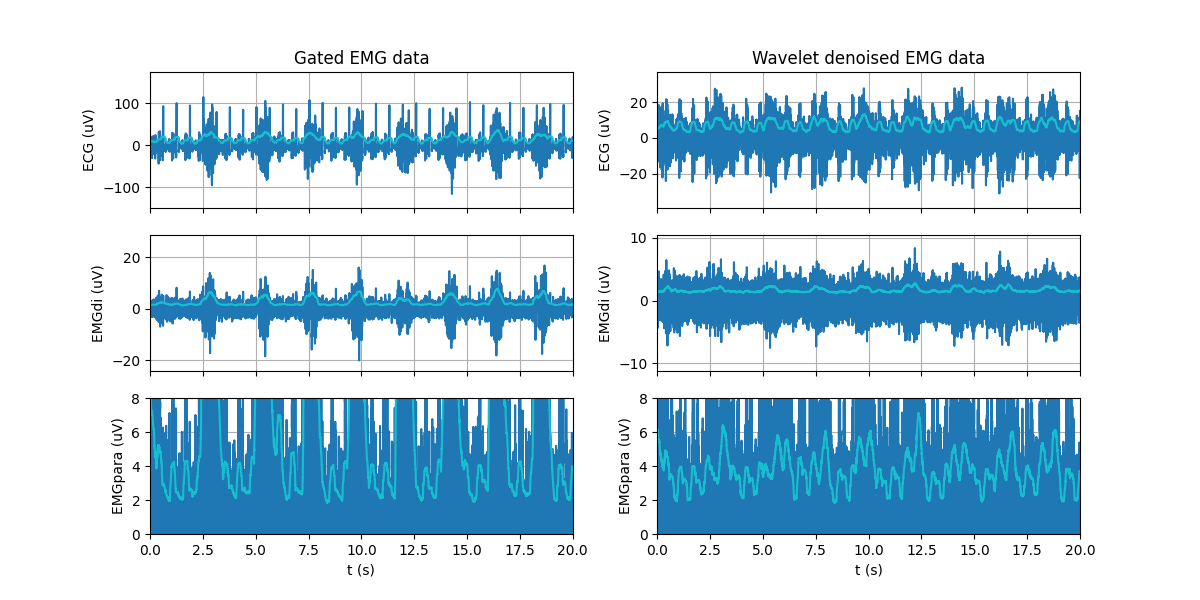

In [18]:
# Plot filtering effect
fig, axis = plt.subplots(nrows=3, ncols=2, figsize=(12, 6), sharex=True)
axes_emg_gated = axis[:len(emg_timeseries_gated.channels), 0]
axes_emg_wav_den = axis[:len(emg_timeseries_wav_den.channels), 1]
colors = ['tab:cyan', 'tab:orange']
channel_idx = 0


# emg_timeseries.plot_full(
#     axes=axes_emg, signal_type='raw', baseline_bool=False)

emg_timeseries_gated.plot_full(
    axes=axes_emg_gated, signal_type='clean', baseline_bool=False)

emg_timeseries_gated.plot_full(
    axes=axes_emg_gated, signal_type='env', colors=colors)

axes_emg_gated[0].set_title('Gated EMG data')
axes_emg_gated[-1].set_xlabel('t (s)')
axes_emg_gated[-1].set_ylim([0, 8])

emg_timeseries_wav_den.plot_full(
    axes=axes_emg_wav_den, signal_type='clean', baseline_bool=False)

emg_timeseries_wav_den.plot_full(
    axes=axes_emg_wav_den, signal_type='env', colors=colors)

axes_emg_wav_den[0].set_title('Gated EMG data')
axes_emg_wav_den[-1].set_xlabel('t (s)')

axes_emg_wav_den[0].set_title('Wavelet denoised EMG data')
axes_emg_wav_den[-1].set_xlabel('t (s)')
axes_emg_wav_den[-1].set_ylim([0, 8])

axes_emg_wav_den[-1].set_xlim([0, 20])

# Compare speed of running median filters

In [ ]:
from scipy.ndimage import median_filter
signal = y_emg
win_len = 5 * fs_emg
k = 0
result_median_filter = median_filter(np.abs(signal[k, :]), size=win_len) / 0.6745
win_len

In [ ]:
import pandas as pd

k = 0
result_pd = pd.Series(np.abs(signal[k, :])).rolling(
        window=win_len,
        min_periods=1,
        center=True).median().values / 0.6745
win_len

In [ ]:
start_i = 2000
np.array([
    result_median_filter,
    result_pd,
])[:, start_i:start_i+5]

In [ ]:
fig, axis = plt.subplots(nrows=3, sharex=True)

axis[0].plot(np.abs(signal[k, :]), 'tab:cyan')
axis[1].plot(result_median_filter, 'tab:blue')
axis[2].plot(result_pd, 'tab:green')